<a href="https://colab.research.google.com/github/Lolo-17/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.datasets.samples_generator import make_blobs
from scipy.spatial import distance

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [ ]:
# Reading the supervised dataset
df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [ ]:
df2 = df.copy()
df2 = df2.drop('diagnosis', axis=1)
# Also dropping id and unamed columns
df2 = df2.drop('Unnamed: 32', axis=1)
df2 = df2.drop('id', axis=1)
df2.head()

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [255]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df2)
labels = kmeans.labels_
df2['clusters'] = kmeans.labels_

In [ ]:
average_squared_distances = []

for k in range(1,11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df2)
  # Average squared distance from points to centroids
  average_squared_distances.append(kmeans.inertia_)

average_squared_distances

In [ ]:
plt.plot(list(range(1,11)), average_squared_distances, 'b-')
plt.xticks(list(range(1,11)), list(range(1,11)))
plt.title("Elbow Method")
plt.show()

In [ ]:
print(len(labels))
print(len(df['diagnosis']))

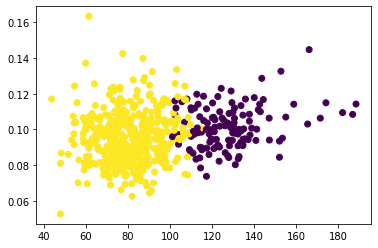

In [259]:
plt.scatter(df2['perimeter_mean'],df2['smoothness_mean'], c=df2['clusters'])
plt.show()

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [260]:
df2['diagnosis'] = df['diagnosis']

In [ ]:
df2.diagnosis[df2.diagnosis == 'M'] = 1 
df2.diagnosis[df2.diagnosis == 'B'] = 0 

In [ ]:
df2.diagnosis.value_counts()

In [ ]:
(df2['clusters'] == df2['diagnosis']).value_counts()

In [ ]:
(df2['clusters'] == df2['diagnosis']).value_counts()[1] / df.shape[0]

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [ ]:
dfp = df.copy()
dfp = dfp.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)
dfp.head()

In [ ]:
# Performing PCA
# Standardize our Data
scaler = StandardScaler()
Z = scaler.fit_transform(dfp)
Z

In [268]:
# Extract new features with PCA
pca = PCA(.9)
new_features = pca.fit_transform(Z)
new_features = pd.DataFrame(new_features)

In [269]:
# Turn our new_features into a dataframe
new_features = pd.DataFrame(new_features)
new_features.columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
new_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213


In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(new_features)
print(kmeans.labels_)

In [271]:
new_features['clusters'] = kmeans.labels_
new_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clusters
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0


In [272]:
new_features['diagnosis'] = df['diagnosis']
new_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clusters,diagnosis
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,0,M
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0,M
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0,M
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,0,M
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0,M


In [ ]:
new_features.diagnosis[new_features.diagnosis == 'M'] = 1 
new_features.diagnosis[new_features.diagnosis == 'B'] = 0 
new_features.head()

In [274]:
(new_features['clusters'] == new_features['diagnosis']).value_counts()[1] / new_features.shape[0]

0.08963093145869948

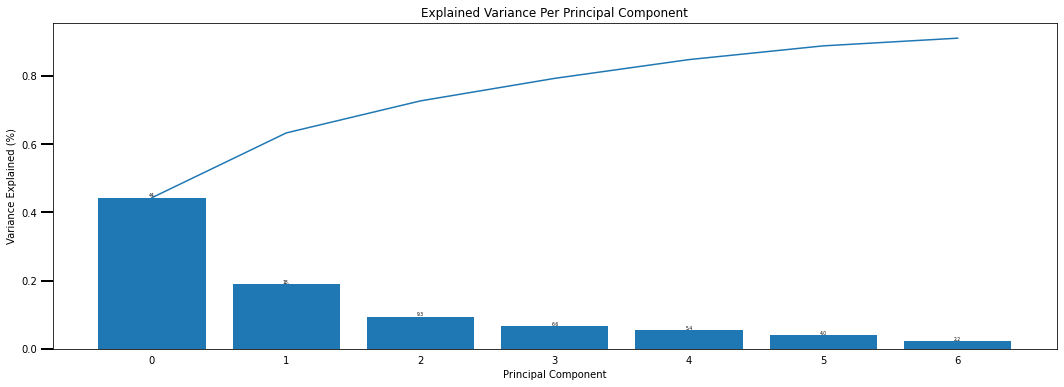

In [277]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

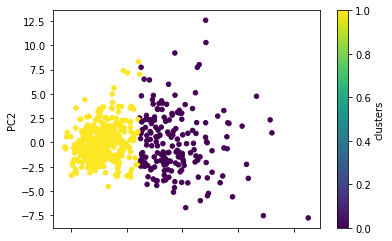

In [278]:
new_features.plot.scatter('PC1', 'PC2', c='clusters', cmap='viridis')
plt.show()

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

Using PCA yields better accuracy than plainly using Kmeans.

PCA > Kmeans

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project